In [102]:
from rfgap import RFGAP
from dataset import dataprep

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

## Read in the data and normalize

In [103]:
# TODO: Test with NumPy and Pandas, ALL METHODS and perhaps combos of each type.

In [104]:
data   = pd.read_csv('../datasets/iris.csv', sep = ',')
x, y   = dataprep(data)
n, d   = x.shape
n_classes = len(y.unique())

In [105]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

## Train the RF Model

In [106]:
rf = RFGAP(y = y_train, prox_method = 'rfgap', matrix_type = 'sparse', oob_score = True,
           random_state = 42)

In [107]:
rf.fit(x_train, y_train)

## Generate the Proximity Matrix

In [108]:
prox = rf.get_proximities()

## Check Sum-to-One

In [109]:
np.sum(prox.toarray(), axis = 1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

## Measures of Trust

### RF-ICE (Trust Scores)

In [110]:
ice_scores = rf.get_instance_classification_expectation()
print(rf.trust_auc)

0.9761036935647303


#### Accuracy Rejection Curve

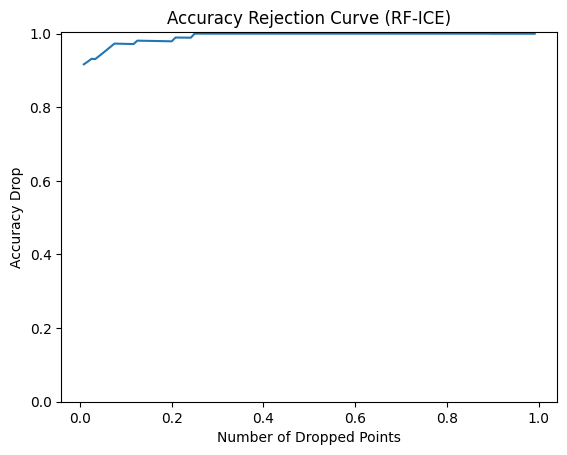

In [111]:
sns.lineplot(x=rf.trust_n_drop, y=rf.trust_accuracy_drop)
plt.xlabel('Number of Dropped Points')
plt.ylabel('Accuracy Drop')
plt.title('Accuracy Rejection Curve (RF-ICE)')
plt.ylim(0, None);

In [112]:
# RF-ICE for Test Set

In [137]:
rf.get_nonconformity(k = 5, x_test = x_test, proximity_type = 'rfgap')

In [140]:
rf.conformity_scores

array([11.04363415, 11.04363415, 11.04363415, 11.04363415, 11.04363415,
       10.7715523 , 11.04363415, 11.04363415, 11.04363415, 11.04363415,
       10.77566691, 11.04363415, 11.04363415, 11.04363415, 11.04363415,
       11.04363415,  9.6565903 , 10.92964763, 11.04363415, 11.04363415,
       11.04363415, 11.04363415, 11.04363415, 11.04363415, 11.04363415,
       11.04363415, 11.04363415, 11.04363415, 11.04363415, 10.80918005,
       10.88884795, 11.04363415, 11.04363415, 11.04363415, 11.04363415,
       11.04363415, 11.04363415, 11.04363415, 11.04363415, 11.04363415,
       10.74153678, 11.04363415,  9.64917791, 10.84882554, 10.15673349,
       10.50019712, 11.04363415, 11.04363415, 11.04363415, 11.0056767 ,
       10.47740661, 11.04363415, 11.04363415, 11.04363415,  4.52375777,
       11.04363415, 11.04363415, 11.04363415, 11.04363415,  0.        ,
       10.89383141, 10.88920537,  6.78273241,  9.48172471, 11.04363415,
       11.04363415, 11.04363415, 11.04363415,  9.12201376, 10.78

Text(0.5, 1.0, 'Scatter Plot of Training Data with Nonconformity Scores')

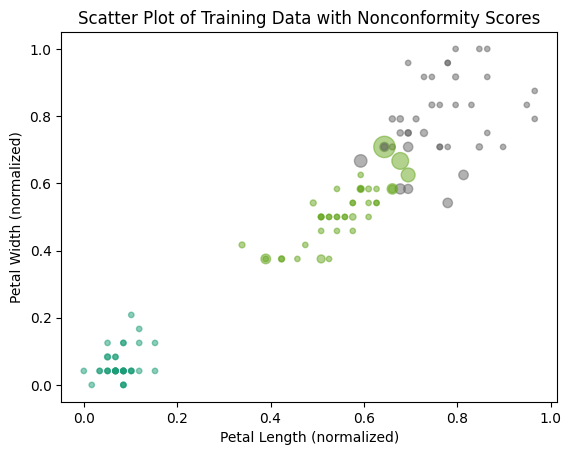

In [138]:
plt.scatter(x_train[:, 2], x_train[:, 3], c=y_train, cmap='Dark2', 
            s=rf.nonconformity_scores * 20 + 15, alpha=0.5)
plt.xlabel('Petal Length (normalized)')
plt.ylabel('Petal Width (normalized)')
plt.title('Scatter Plot of Training Data with Nonconformity Scores')

Text(0.5, 1.0, 'Conformity Accuracy Rejection Curve')

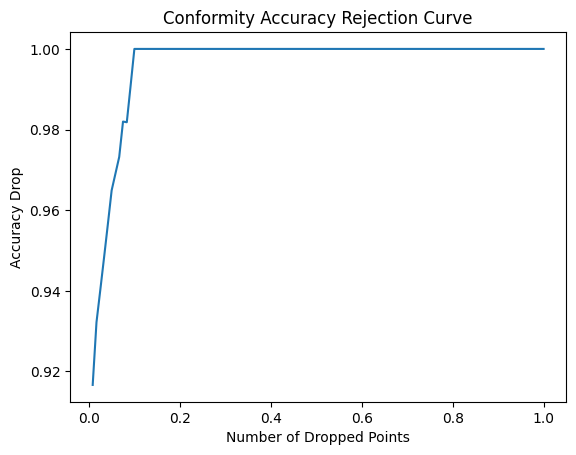

In [142]:
sns.lineplot(x=rf.conformity_n_drop, y=rf.conformity_accuracy_drop)
plt.xlabel('Number of Dropped Points')
plt.ylabel('Accuracy Drop')
plt.title('Conformity Accuracy Rejection Curve')

In [ ]:
self.conformity_auc, self.conformity_accuracy_drop, self.conformity_n_drop = self.accuracy_rejection_auc(
                    self.conformity_quantiles, self.conformity_scores
                )

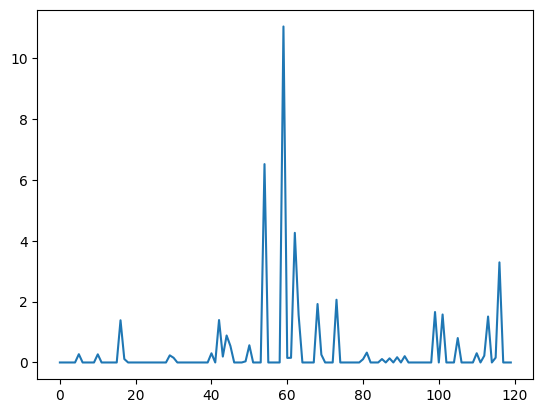

In [114]:
plt.plot(rf.nonconformity_scores)

In [115]:
                # Updates the following attributes:
                # - `self.nonconformity_scores`
                # - `self.conformity_scores`
                # - `self.conformity_quantiles`
                # - `self.conformity_auc`
                # - `self.conformity_accuracy_drop`
                # - `self.conformity_n_drop`
                
                # If `x_test` is provided, also updates:
                # - `self.nonconformity_scores_test`
                # - `self.conformity_scores_test`
                # - `self.conformity_quantiles_test`